## Tree Mortality Coding Template

### Setup

**Note that you will be asked to input the shapefile file path of the region you want to analyze AND the TIFF file path for your regional DEM.**

In [ ]:
# Import Packages
from pathlib import Path
import arcpy
from arcpy.sa import *
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy import stats

# Set Script Directory
try:
    script_directory = Path(__file__).resolve().parent
except NameError:
    script_directory = Path.cwd()

# Set Project Root and Data Directory
project_root = script_directory.parent
data_directory = project_root/"Data"

# Set Arcpy Environments
arcpy.env.workspace = str(data_directory)
arcpy.env.overwriteOutput = True

# Load datasets 
polygon_site = input("Input polygon shapefile file path: ")
tree_mortality = Raster(str(data_directory/"Input_Data"/"Tree_Mortality"/"East_Coast_Tree_Mortality.tif"))
inundation_frequency = Raster(str(data_directory/"Input_Data"/"Inundation_Frequency"/"InundFreq_NC_Coast_2017-2024_mosaic.tif"))
land_cover = Raster(str(data_directory/"Input_Data"/"Land_Cover"/"NC_Coastal_Land_Cover_2021_CCAP_J1249552tR0_C0.tif"))
estuary_euclidian_distance = Raster(str(data_directory/"Input_Data"/"Euclidian_Distance"/"coastline_euc_dist.tif"))
artificial_drainage_euclidian_distance = Raster(str(data_directory/"Input_Data"/"Euclidian_Distance"/"artificial_drainage_euc_dist.tif"))
elevation_DEM = input("Input Digital Elevation Model (DEM) file path (.tif): ")

# Create a file path to save your dissolved polygon in the "Dissolved_Polygons" folder within "Output_Data"
dissolved_polygon_site_path = str(data_directory/"Output_Data"/"Dissolved_Polygons"/"dissolved_polygon_site.tif")

# Dissolve your multi-polygon sites into one polygon for analyses
arcpy.management.Dissolve(polygon_site,dissolved_polygon_site_path)

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Dissolved_Polygons\\dissolved_polygon_site.shp">

### Tree Mortality

In [2]:
# Mask tree mortality raster to polygon site
masked_tree_raster = arcpy.sa.ExtractByMask(tree_mortality, polygon_site)

# Save the masked tree raster created using arcpy.sa.ExtractByMask above to the "Tree_Mortalty" folder within "Output_Data"
masked_tree_path = str(data_directory/"Output_Data"/"Tree_Mortality"/"tree_mortality_site_mask.tif")
masked_tree_raster.save(masked_tree_path)

In [3]:
# Use arcpy.Raster to create an arcpy tree mortality raster
tree_mortality_raster = arcpy.Raster(masked_tree_path)

In [4]:
# Create a single-banded raster from the tree mortality raster that solely depicts counts of dead trees/per pixel
arcpy.management.MakeRasterLayer(in_raster=tree_mortality_raster,
                                 out_rasterlayer="tree_count.tif",
                                 where_clause="#",
                                 envelope="#",
                                 band_index="1")

# Create a path to save the single-banded tree mortality raster to the "Tree Mortality" folder within "Output_Data"
dead_tree_count_path = str(data_directory/"Output_Data"/"Tree_Mortality"/"single_band_tree_mortality.tif")

# Copy the resulting raster from the arcpy.management.MakeRasterLayer analysis above and save to the dead_tree_count_path defined above
arcpy.management.CopyRaster(in_raster="tree_count.tif",
                            out_rasterdataset= dead_tree_count_path)

# Use arcpy.Raster to create a single-banded tree raster depicting dead trees/pixel counts for your site of interest
single_band_tree_raster = arcpy.Raster(dead_tree_count_path)

### Inundation Frequency

In [5]:
# Mask inundation frequency raster to polygon site
masked_inundation_raster = arcpy.sa.ExtractByMask(inundation_frequency, polygon_site)

# Save the masked inundation frequency raster created using arcpy.sa.ExtractByMask above to the "Inundation_Frequency" folder within "Output_Data"
masked_inundation_path = str(data_directory/"Output_Data"/"Inundation_Frequency"/"inundation_frequency_site_mask.tif")
masked_inundation_raster.save(masked_inundation_path)

In [6]:
# Use arcpy.Raster to create an arcpy inundation frequency raster for analysis
inundation_frequency_raster = arcpy.Raster(masked_inundation_path) 

In [7]:
# Create a conditional live tree inundation frequency raster where inundation frequency values are returned in locations where dead trees/pixel is equal to 0, indicating that region of forest is live
live_tree_inundation_raster = Con((single_band_tree_raster == 0), inundation_frequency_raster)

# Save live tree inundation frequency raster to the "Inundation_Frequency" folder within "Output_Data"
live_tree_inundation_raster.save(str(data_directory/"Output_Data"/"Inundation_Frequency"/"live_tree_inundation_raster.tif"))

In [8]:
# Create a conditional dead tree inundation frequency raster where inundation frequency values are returned in locations where dead trees/pixel is greater than 0, indicating regions that contain at least one dead tree/pixel
dead_tree_inundation_raster = Con((single_band_tree_raster > 0), inundation_frequency_raster)

# Save dead tree inundation frequency raster to the "Inundation_Frequency" folder within "Output_Data"
dead_tree_inundation_raster.save(str(data_directory/"Output_Data"/"Inundation_Frequency"/"dead_tree_inundation_raster.tif"))

#### Median Inundation Frequency by Tree Mortality Bin Class

In [9]:
# Compute the maximum number of dead trees/pixel with your site of interest
maximum_tree_value = arcpy.GetRasterProperties_management(single_band_tree_raster,"MAXIMUM").getOutput(0)

# Convert the results of the maximum number of dead trees/pixel to be a floating integer value
maximum_tree_value = int(float(maximum_tree_value))

# Define dashmark
en_dash = "\u2013"

# Create labels list
tree_threshold_bins = [1, 2, 5, 11, 21, maximum_tree_value + 1]

# Define label classes
labels = [
    "1",
    f"2{en_dash}4",
    f"5{en_dash}10",
    f"11{en_dash}20",
    "21+"
]

In [10]:
# Create an empty median inundation frequency list to store median values that correspond to the predefined adjusted bin classes
median_inundation_values = []

# Define edges
edges = tree_threshold_bins

# Iterate through the adjusted bins (edges) to calculate the tree mortality and pixel count within each bin class, where lower = the lower threhsold of each bin and upper = the upper threshold of each bin
for i in range(len(edges) - 1):
    lower = int(edges[i])
    upper = int(edges[i + 1]) - 1
    tree_threshold_mask = Con((single_band_tree_raster >= lower) & (single_band_tree_raster <= upper), 1) # create a conditional tree threshold mask that returns tree mortality within each adjusted bin class
    tree_threshold_array = arcpy.RasterToNumPyArray(tree_threshold_mask, nodata_to_value = 0) # create an array from the tree_threshold_mask above and list "No Data" value as 0
    pixel_count = np.count_nonzero(tree_threshold_array) # list the pixel count for dead trees within each adjusted bin class 

# Compute zonal statistics to retrieve median inundation frequency values that correspond to tree mortality within each adjusted bin class
    arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = tree_threshold_mask,
        zone_field= "Value",
        in_value_raster=inundation_frequency_raster,
        out_table= str(data_directory/"Output_Data"/"Inundation_Frequency"/"zonal_stats_inundation_threshold_gradient.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
        )

# Add median inundation frequency values to empty list by referencing the output table from the above Zonal Statistics as Table analysis
    with arcpy.da.SearchCursor(str(data_directory/"Output_Data"/"Inundation_Frequency"/"zonal_stats_inundation_threshold_gradient.dbf"),["MEDIAN"]) as cursor:
        for row in cursor:
            median_inundation = row[0]
            median_inundation_values.append({
                "Lower Threshold": lower, # lower bin threshold
                "Upper Threshold": upper, # upper bin threshold
                "Pixel Count": pixel_count,
                "Median Inundation Frequency (%)": median_inundation})

# Create a Pandas dataframe containing median inundation frequency values that correspond to each adjusted bin class
inundation_frequency_df = pd.DataFrame(median_inundation_values)

In [11]:
# View the results of the inundation frequency dataframe
inundation_frequency_df

,Lower Threshold,Upper Threshold,Pixel Count,Median Inundation Frequency (%)
0,1,1,45448,0.257384
1,2,4,30386,0.274262
2,5,10,9597,0.303797
3,11,20,2950,0.329114
4,21,54,719,0.364407


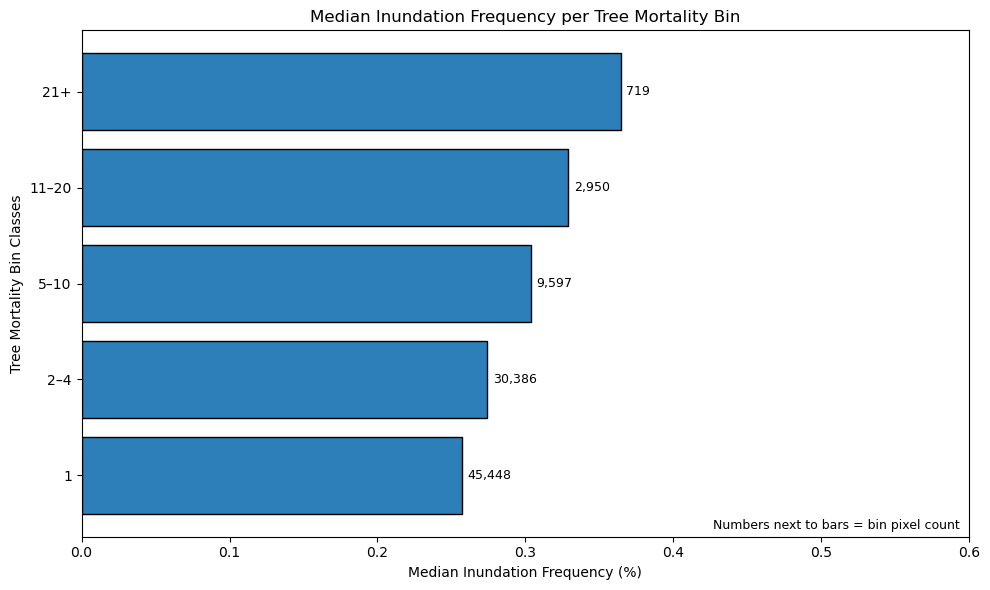

In [12]:
# Create labels for plot
inund_x = np.arange(len(inundation_frequency_df))
inund_y_median = inundation_frequency_df["Median Inundation Frequency (%)"].astype(float)
inund_y_count = inundation_frequency_df["Pixel Count"].astype(int)

# Define dashmark
en_dash = "\u2013"

# Create mortality bin
inundation_frequency_df["Bin Label"] = [
    str(int(row["Lower Threshold"])) if i == 0 else
    f"{int(row['Lower Threshold'])}+" if i == len(inundation_frequency_df)-1 else
    f"{int(row['Lower Threshold'])}\u2013{int(row['Upper Threshold'])}"
    for i, row in inundation_frequency_df.iterrows()
]

# Create labels
labels = inundation_frequency_df["Bin Label"].tolist()

# Create figure, axes, and bars
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(inund_x, inund_y_median, color="#2C7FB8", edgecolor="black")

# Set maximum x-axis limit
x_fixed_max = 0.6      
x_threshold = 0.6       

# Calcualte new maximum for x-axis, if threshold is exceeded
data_max = inund_y_median.max()

if data_max <= x_threshold:
    ax.set_xlim(0, x_fixed_max)
else:
    ax.set_xlim(0, data_max * 1.15)

# Plot labels and formatting
ax.set_yticks(inund_x)
ax.set_yticklabels(labels=labels)
ax.set_xlim(0, 0.6)
ax.set_xlabel("Median Inundation Frequency (%)")
ax.set_ylabel("Tree Mortality Bin Classes")
ax.set_title("Median Inundation Frequency per Tree Mortality Bin")
ax.text(
    0.99, 0.01,
    "Numbers next to bars = bin pixel count",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
    color="black"
)

# Add pixel counts to the right of each bar
for i, (val, cnt) in enumerate(zip(inund_y_median, inund_y_count)):
    ax.text(val + (inund_y_median.max()*0.01),  # small offset to the right
            i,
            f"{cnt:,}",
            va="center",
            fontsize=9)

# Plot and save figure
plt.tight_layout()
plt.savefig(
    str(data_directory/"Output_Data"/"Figure_Outputs"/"inundation_frequency.png"),
    bbox_inches="tight"
)
plt.show()

### Land Cover

In [13]:
# Mask land cover data to polygon site
masked_landcover_raster = arcpy.sa.ExtractByMask(land_cover,polygon_site)

# Save the masked land cover raster created using arcpy.sa.ExtractByMask above to the "Land_Cover" folder within "Output_Data"
masked_landcover_path = str(data_directory/"Output_Data"/"Land_Cover"/"land_cover_site_mask.tif")
masked_landcover_raster.save(masked_landcover_path)

In [14]:
# Use arcpy.Raster to create an arcpy land cover raster for analysis
landcover_raster = arcpy.Raster(masked_landcover_path)

#### Dead Tree Analysis (Land Cover)

In [15]:
# Create a masked raster for dead trees
dead_tree_mask = Con((single_band_tree_raster > 0), single_band_tree_raster)
dead_tree_mask.save(str(data_directory/"Output_Data"/"Land_Cover"/"dead_tree_mask.tif"))

In [16]:
# Retrieve the sum of total number of dead trees per land cover class
arcpy.sa.ZonalStatisticsAsTable(in_zone_data=masked_landcover_path,
                                zone_field="LABELS",
                                in_value_raster=dead_tree_mask,
                                out_table=str(data_directory/"Output_Data"/"Land_Cover"/"zonal_stats_dead_tree_landcover.dbf"),
                                ignore_nodata="DATA",
                                statistics_type="SUM")

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Land_Cover\\zonal_stats_dead_tree_landcover.dbf">

In [17]:
# Create an array for tree mortality per land cover class using the table output from the previous Zonal Statistics as Table tool
dead_tree_landcover_table = str(data_directory/"Output_Data"/"Land_Cover"/"zonal_stats_dead_tree_landcover.dbf")
dead_tree_landcover_array = arcpy.da.TableToNumPyArray(dead_tree_landcover_table, "*")
df3 = pd.DataFrame(dead_tree_landcover_array)

In [18]:
# Create landcover subclasses
landcover_subset_class = [
    "Deciduous Forest",
    "Evergreen Forest"
    "Mixed Forest",
    "Scrub/Shrub",
    "Palustrine Forested Wetland",
    "Palustrine Scrub/Shrub Wetland",
    "Estuarine Forested Wetland",
    "Estuarine Scrub/Shrub Wetland"
    ]

# Create a new dead tree subset dataframe from our dead tree landcover dataframe to only display classes of interest
landcover_subset_dead_df = df3[df3["LABELS"].isin(landcover_subset_class)]

# Rename the "LABELS", "SUM", and "AREA" columns for better readability
landcover_subset_dead_df = landcover_subset_dead_df.rename(columns={"LABELS":"Land Cover Class","SUM": "Total Dead Trees", "COUNT":"Pixel Count (Dead)"})
print(landcover_subset_dead_df[['Land Cover Class','Total Dead Trees','Pixel Count (Dead)']])

                 Land Cover Class  Total Dead Trees  Pixel Count (Dead)
4                     Scrub/Shrub               9.0                 6.0
5     Palustrine Forested Wetland          198610.0             73390.0
6  Palustrine Scrub/Shrub Wetland           29982.0             10094.0
8   Estuarine Scrub/Shrub Wetland             225.0                85.0


#### Area Percentage Analysis

In [19]:
# Create a masked raster for live trees
live_tree_mask = Con((single_band_tree_raster == 0), single_band_tree_raster)
live_tree_mask.save(str(data_directory/"Output_Data"/"Land_Cover"/"live_tree_mask.tif"))

In [20]:
# Retrieve the sum of total number of live trees per land cover class
arcpy.sa.ZonalStatisticsAsTable(in_zone_data=masked_landcover_path,
                                zone_field="LABELS",
                                in_value_raster=live_tree_mask,
                                out_table=str(data_directory/"Output_Data"/"Land_Cover"/"zonal_stats_live_tree_landcover.dbf"),
                                ignore_nodata="DATA",
                                statistics_type="SUM")

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Land_Cover\\zonal_stats_live_tree_landcover.dbf">

In [21]:
# Create an array for live forest per land cover class using the table output from the previous Zonal Statistics as Table tool
live_tree_landcover_table = str(data_directory/"Output_Data"/"Land_Cover"/"zonal_stats_live_tree_landcover.dbf")
live_tree_landcover_array = arcpy.da.TableToNumPyArray(live_tree_landcover_table, "*")
df4 = pd.DataFrame(live_tree_landcover_array)

In [22]:
# Create a new live tree subset dataframe from our live tree landcover dataframe to only display classes of interest
landcover_subset_live_df = df4[df4["LABELS"].isin(landcover_subset_class)]

# Rename the "LABELS" and "SUM" columns for better readability
landcover_subset_live_df = landcover_subset_live_df.rename(columns={"LABELS":"Land Cover Class","COUNT":"Pixel Count (Live)"})
print(landcover_subset_live_df[['Land Cover Class','Pixel Count (Live)']])

                  Land Cover Class  Pixel Count (Live)
5                 Deciduous Forest                 1.0
8                      Scrub/Shrub                55.0
9      Palustrine Forested Wetland            342589.0
10  Palustrine Scrub/Shrub Wetland             91794.0
12   Estuarine Scrub/Shrub Wetland              3233.0


In [23]:
# Remove duplicate column names if they exist
landcover_subset_live_df = landcover_subset_live_df.loc[:, ~landcover_subset_live_df.columns.duplicated()]

# Join live tree and dead tree subset dataframes
landcover_subset_dead_df = landcover_subset_dead_df.merge(
    landcover_subset_live_df[["Land Cover Class","Pixel Count (Live)"]],
    on="Land Cover Class",
    how="left"
)

In [24]:
# Calculate percentage of land cover class experiencing mortality
landcover_subset_dead_df["% Experiencing Mortality"] = (
    landcover_subset_dead_df["Pixel Count (Dead)"] /
    (landcover_subset_dead_df["Pixel Count (Dead)"] + landcover_subset_dead_df["Pixel Count (Live)"])
) * 100

# Display final table results
print(landcover_subset_dead_df[['Land Cover Class','Total Dead Trees','Pixel Count (Dead)','Pixel Count (Live)','% Experiencing Mortality']])

# Export final land cover table to CSV
landcover_subset_dead_df.to_csv(str(data_directory/"Output_Data"/"Figure_Outputs"/"land_cover_site_summary.csv"))

                 Land Cover Class  Total Dead Trees  Pixel Count (Dead)  \
0                     Scrub/Shrub               9.0                 6.0   
1     Palustrine Forested Wetland          198610.0             73390.0   
2  Palustrine Scrub/Shrub Wetland           29982.0             10094.0   
3   Estuarine Scrub/Shrub Wetland             225.0                85.0   

   Pixel Count (Live)  % Experiencing Mortality  
0                55.0                  9.836066  
1            342589.0                 17.642718  
2             91794.0                  9.906957  
3              3233.0                  2.561784  


### Distance to Estuary

In [25]:
# Create reference for NAD 1983 UTM Zone 17N projected coordinate system
utm_epsg = arcpy.SpatialReference(26917)

# Convert tree raster to NAD 1983 UTM Zone 17N
tree_raster_utm = arcpy.ProjectRaster_management(in_raster=single_band_tree_raster,
                         out_raster=str(data_directory/"Output_Data"/"Distance_to_Coast"/"tree_raster_utm.tif"),
                         out_coor_system=utm_epsg)

In [26]:
# Create conditional raster for distances of dead trees to estuary
dead_tree_estuary_distance = Con(Raster(tree_raster_utm)> 0, estuary_euclidian_distance)

# Save dead tree estuary distance raster to the "Distance_to_Coast" folder within "Output_Data"
dead_tree_estuary_distance.save(str(data_directory/"Output_Data"/"Distance_to_Coast"/"dead_tree_estuary_distance_raster.tif"))

In [27]:
# Create conditional raster for distances of live trees to coast
live_tree_estuary_distance = Con(Raster(tree_raster_utm) == 0, estuary_euclidian_distance)

# Save live tree estuary distance raster to the "Distance_to_Coast" folder within "Output_Data"
live_tree_estuary_distance.save(str(data_directory/"Output_Data"/"Distance_to_Coast"/"live_tree_distance_raster.tif"))

#### Median Distance to Estuary by Tree Mortality Bin Class

In [28]:
# Create an empty median distance to estuary list to store median values that correspond to the predefined adjusted bin classes
median_est_distances = []

edges = tree_threshold_bins

# Iterate through the adjusted bins (edges) to calculate the tree mortality and pixel count within each bin class, where lower = the lower threhsold of each bin and upper = the upper threshold of each bin
for i in range(len(edges) - 1):
    lower = int(edges[i])
    upper = int(edges[i + 1]) - 1
    tree_threshold_mask = Con((single_band_tree_raster >= lower) & (single_band_tree_raster <= upper), 1) # create a conditional tree threshold mask that returns tree mortality within each adjusted bin class
    tree_threshold_array = arcpy.RasterToNumPyArray(tree_threshold_mask, nodata_to_value = 0) # create an array from the tree_threshold_mask above and list "No Data" value as 0
    pixel_count = np.count_nonzero(tree_threshold_array) # list the pixel count for dead trees within each adjusted bin class

# Compute zonal statistics to retrieve median distance to estuarine coastline values that correspond to tree mortality within each adjusted bin class
    arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = tree_threshold_mask,
        zone_field= "Value",
        in_value_raster=estuary_euclidian_distance,
        out_table= str(data_directory/"Output_Data"/"Distance_to_Coast"/"zonal_stats_euclidian_distance_estuary_gradient.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
    )

# Add median distance to estuary values to empty list by referencing the output table from the above Zonal Statistics as Table analysis
    with arcpy.da.SearchCursor(str(data_directory/"Output_Data"/"Distance_to_Coast"/"zonal_stats_euclidian_distance_estuary_gradient.dbf"),["MEDIAN"]) as cursor:
        for row in cursor:
            median_est_dist = row[0]
            median_est_distances.append({
                "Lower Threshold": lower,
                "Upper Threshold": upper,
                "Pixel Count": pixel_count,
                "Median Distance (m)": median_est_dist})

# Create a Pandas dataframe containing median distance to estuarine coastline values that correspond to each adjusted bin class
distance_coast_df = pd.DataFrame(median_est_distances)

In [29]:
# View the results of the distance to coast dataframe
distance_coast_df

,Lower Threshold,Upper Threshold,Pixel Count,Median Distance (m)
0,1,1,45448,1672.752197
1,2,4,30386,1556.823730
2,5,10,9597,1489.765137
3,11,20,2950,1608.990112
4,21,54,719,1954.379639


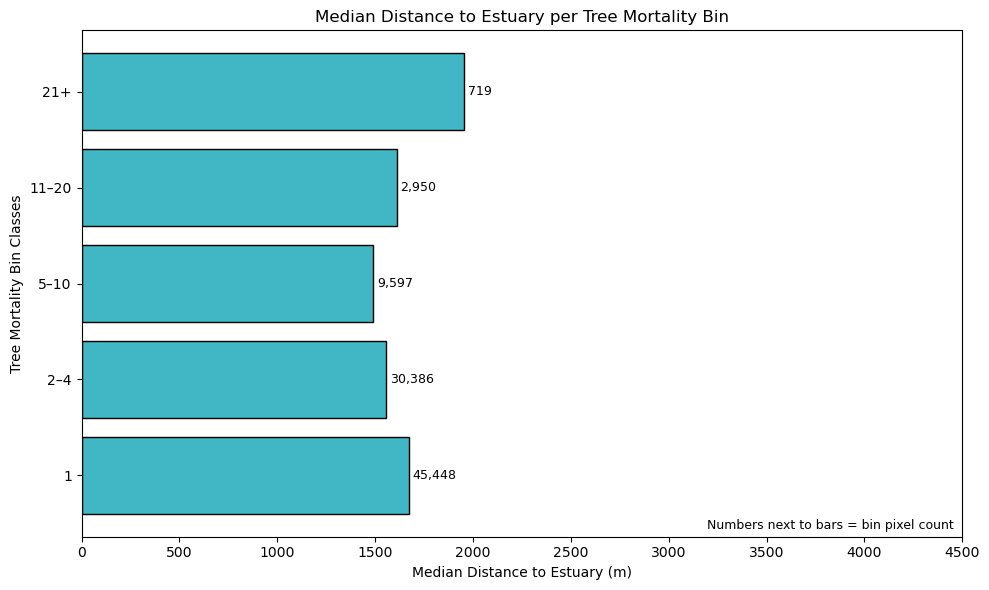

In [30]:
# Create labels for plot
est_dist_x = np.arange(len(distance_coast_df))
est_dist_y_median = distance_coast_df["Median Distance (m)"].astype(float)
est_dist_y_count = distance_coast_df["Pixel Count"].astype(int)

# Create mortality bin
distance_coast_df["Bin Label"] = [
    str(int(row["Lower Threshold"])) if i == 0 else
    f"{int(row['Lower Threshold'])}+" if i == len(distance_coast_df)-1 else
    f"{int(row['Lower Threshold'])}\u2013{int(row['Upper Threshold'])}"
    for i, row in distance_coast_df.iterrows()
]

# Create labels
labels = distance_coast_df["Bin Label"].tolist()

# Create figure, axes, and bars
fig2, ax2 = plt.subplots(figsize=(10, 6))
bars2 = ax2.barh(est_dist_x, est_dist_y_median, color="#41B6C4", edgecolor="black")

# Set maximum x-axis limit
x_fixed_max = 4500      
x_threshold = 4500      

# Calcualte new maximum for x-axis, if threshold is exceeded
data_max = est_dist_y_median.max()

if data_max <= x_threshold:
    ax2.set_xlim(0, x_fixed_max)
else:
    ax2.set_xlim(0, data_max * 1.15)

# Plot labels and formatting
ax2.set_yticks(est_dist_x)
ax2.set_yticklabels(distance_coast_df["Bin Label"])
ax2.set_xlabel("Median Distance to Estuary (m)")
ax2.set_ylabel("Tree Mortality Bin Classes")
ax2.set_title("Median Distance to Estuary per Tree Mortality Bin")
ax2.text(
    0.99, 0.01,
    "Numbers next to bars = bin pixel count",
    transform=ax2.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
    color="black"
)

# Add pixel counts to the right of each bar
for i, (val, cnt) in enumerate(zip(est_dist_y_median, est_dist_y_count)):
    ax2.text(val + (est_dist_y_median.max()*0.01),  # small offset to the right
            i,
            f"{cnt:,}",
            va="center",
            fontsize=9)

# Plot and save figure
plt.tight_layout()
plt.savefig(
    str(data_directory/"Output_Data"/"Figure_Outputs"/"distance_to_coast.png"),
    bbox_inches="tight"
)
plt.show()

### Distance to Artificial Drainage Network

In [31]:
# Create conditional raster for distances of dead trees to artificial drainage network
dead_tree_adn_distance = Con(Raster(tree_raster_utm)> 0, artificial_drainage_euclidian_distance)

# Save dead tree artificial drainage raster to the "Distance_to_ADN" folder within "Output_Data"
dead_tree_adn_distance.save(str(data_directory/"Output_Data"/"Distance_to_ADN"/"dead_tree_adn_distance.tif"))

In [32]:
# Create conditional raster for distances of live trees to artificial drainage network
live_tree_adn_distance= Con(Raster(tree_raster_utm)== 0, artificial_drainage_euclidian_distance)

# Save live tree artificial drainage raster to the "Distance_to_ADN" folder within "Output_Data"
live_tree_adn_distance.save(str(data_directory/"Output_Data"/"Distance_to_ADN"/"live_tree_adn_distance.tif"))

#### Median Distance to Artificial Drainage Network by Tree Mortality Bin Class

In [33]:
# Create an empty median distance to artificial drainage network list to store median values that correspond to the predefined adjusted bin classes
median_adn_distances = []

# Define edges
edges = tree_threshold_bins

# Iterate through the adjusted bins (edges) to calculate the tree mortality and pixel count within each bin class, where lower = the lower threhsold of each bin and upper = the upper threshold of each bin
for i in range(len(edges) - 1):
    lower = int(edges[i])
    upper = int(edges[i + 1]) - 1
    tree_threshold_mask = Con((single_band_tree_raster >= lower) & (single_band_tree_raster <= upper), 1) # create a conditional tree threshold mask that returns tree mortality within each adjusted bin class
    tree_threshold_array = arcpy.RasterToNumPyArray(tree_threshold_mask, nodata_to_value = 0) # create an array from the tree_threshold_mask above and list "No Data" value as 0
    pixel_count = np.count_nonzero(tree_threshold_array) # list the pixel count for dead trees within each adjusted bin class

# Compute zonal statistics to retrieve median distance to artificial drainage network values that correspond to tree mortality within each adjusted bin class
    arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = tree_threshold_mask,
        zone_field= "Value",
        in_value_raster=artificial_drainage_euclidian_distance,
        out_table= str(data_directory/"Output_Data"/"Distance_to_ADN"/"zonal_stats_euclidian_distance_adn_gradient.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
    )

# Add median distance to artificial drainage network values to empty list by referencing the output table from the above Zonal Statistics as Table analysis
    with arcpy.da.SearchCursor(str(data_directory/"Output_Data"/"Distance_to_ADN"/"zonal_stats_euclidian_distance_adn_gradient.dbf"),["MEDIAN"]) as cursor:
        for row in cursor:
            median_adn_dist = row[0]
            median_adn_distances.append({
                "Lower Threshold": lower,
                "Upper Threshold": upper,
                "Pixel Count": pixel_count,
                "Median Distance (m)": median_adn_dist
                })
            
# Create a Pandas dataframe containing median distance to artificial drainage values that correspond to each adjusted bin class
distance_adn_df = pd.DataFrame(median_adn_distances)

In [34]:
# View the results of the distance to artificial drainage network dataframe
distance_adn_df

,Lower Threshold,Upper Threshold,Pixel Count,Median Distance (m)
0,1,1,45448,420.000000
1,2,4,30386,450.000000
2,5,10,9597,450.000000
3,11,20,2950,510.000000
4,21,54,719,569.209961


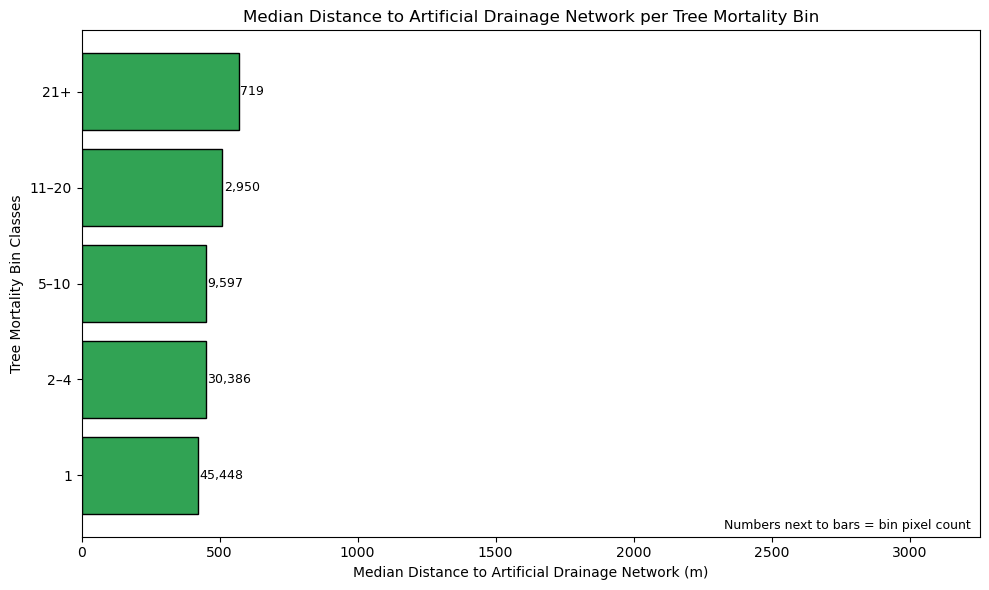

In [35]:
# Create labels for plot
adn_dist_x = np.arange(len(distance_adn_df))
adn_dist_y_median = distance_adn_df["Median Distance (m)"].astype(float)
adn_dist_y_count = distance_adn_df["Pixel Count"].astype(int)

# Create mortality bin
distance_adn_df["Bin Label"] = [
    str(int(row["Lower Threshold"])) if i == 0 else
    f"{int(row['Lower Threshold'])}+" if i == len(distance_adn_df)-1 else
    f"{int(row['Lower Threshold'])}\u2013{int(row['Upper Threshold'])}"
    for i, row in distance_adn_df.iterrows()
]

# Create labels
labels = distance_adn_df["Bin Label"].tolist()

# Create figure, axes, and bars
fig3, ax3 = plt.subplots(figsize=(10, 6))
bars3 = ax3.barh(adn_dist_x, adn_dist_y_median, color="#31A354", edgecolor="black")

# Set maximum x-axis limit
x_fixed_max = 3100      
x_threshold = 3100       

# Calcualte new maximum for x-axis, if threshold is exceeded
data_max = adn_dist_y_median.max()

if data_max <= x_threshold:
    ax3.set_xlim(0, x_fixed_max * 1.05)
else:
    ax3.set_xlim(0, data_max * 1.15)

# Plot labels and formatting
ax3.set_yticks(adn_dist_x)
ax3.set_yticklabels(distance_adn_df["Bin Label"])
ax3.set_xlabel("Median Distance to Artificial Drainage Network (m)")
ax3.set_ylabel("Tree Mortality Bin Classes")
ax3.set_title("Median Distance to Artificial Drainage Network per Tree Mortality Bin")
ax3.text(
    0.99, 0.01,
    "Numbers next to bars = bin pixel count",
    transform=ax3.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
    color="black"
)

# Add pixel counts to the right of each bar
for i, (val, cnt) in enumerate(zip(adn_dist_y_median, adn_dist_y_count)):
    ax3.text(val + (adn_dist_y_median.max()*0.01),  # small offset to the right
            i,
            f"{cnt:,}",
            va="center",
            fontsize=9)

# Plot and save figure
plt.tight_layout()
plt.savefig(
    str(data_directory/"Output_Data"/"Figure_Outputs"/"distance_to_adn.png"),
    bbox_inches="tight"
)
plt.show()

### Elevation

In [36]:
# Use arcpy.Raster to create an arcpy DEM raster for analysis
elevation_raster = arcpy.Raster(elevation_DEM)

In [37]:
# Create a live tree elevation raster
live_tree_elevation_raster = Con((single_band_tree_raster == 0), elevation_raster)

# Save live tree elevation raster to the "Elevation" folder within "Output_Data"
live_tree_elevation_raster.save(str(data_directory/"Output_Data"/"Elevation"/"live_tree_elevation_raster.tif"))

In [38]:
# Create a dead tree elevation raster
dead_tree_elevation_raster = Con((single_band_tree_raster > 0), elevation_raster)

# Save dead tree elevation raster to the "Elevation" folder within "Output_Data"
dead_tree_elevation_raster.save(str(data_directory/"Output_Data"/"Elevation"/"dead_tree_elevation_raster.tif"))

#### Median Elevation by Tree Mortality Bin Class

In [39]:
# Create an empty median elevation list to store median values that correspond to the predefined adjusted bin classes
median_elevation_values = []

# Define edges
edges = tree_threshold_bins

# Iterate through the adjusted bins (edges) to calculate the tree mortality and pixel count within each bin class, where lower = the lower threhsold of each bin and upper = the upper threshold of each bin
for i in range(len(edges) - 1):
    lower = int(edges[i])
    upper = int(edges[i + 1]) - 1
    tree_threshold_mask = Con((single_band_tree_raster >= lower) & (single_band_tree_raster <= upper), 1) # create a conditional tree threshold mask that returns tree mortality within each adjusted bin class
    tree_threshold_array = arcpy.RasterToNumPyArray(tree_threshold_mask, nodata_to_value = 0) # create an array from the tree_threshold_mask above and list "No Data" value as 0
    pixel_count = np.count_nonzero(tree_threshold_array) # list the pixel count for dead trees within each adjusted bin class

# Compute zonal statistics to retrieve median elevation values that correspond to tree mortality within each adjusted bin class
    arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = tree_threshold_mask,
        zone_field= "Value",
        in_value_raster=elevation_raster,
        out_table= str(data_directory/"Output_Data"/"Elevation"/"zonal_stats_elevation_gradient.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
    )

# Add median elevation values to empty list by referencing the output table from the above Zonal Statistics as Table analysis
    with arcpy.da.SearchCursor(str(data_directory/"Output_Data"/"Elevation"/"zonal_stats_elevation_gradient.dbf"),["MEDIAN"]) as cursor:
        for row in cursor:
            median_elevation = row[0]
            median_elevation_values.append({
                "Lower Threshold": lower,
                "Upper Threshold": upper,
                "Pixel Count": pixel_count,
                "Median Elevation (m)": median_elevation})

# Create a Pandas dataframe containing median elevation values that correspond to each adjusted bin class
elevation_df = pd.DataFrame(median_elevation_values)

In [40]:
# View the results of the elevation dataframe
elevation_df

,Lower Threshold,Upper Threshold,Pixel Count,Median Elevation (m)
0,1,1,45448,0.481584
1,2,4,30386,0.475488
2,5,10,9597,0.435864
3,11,20,2950,0.393192
4,21,54,719,0.475488


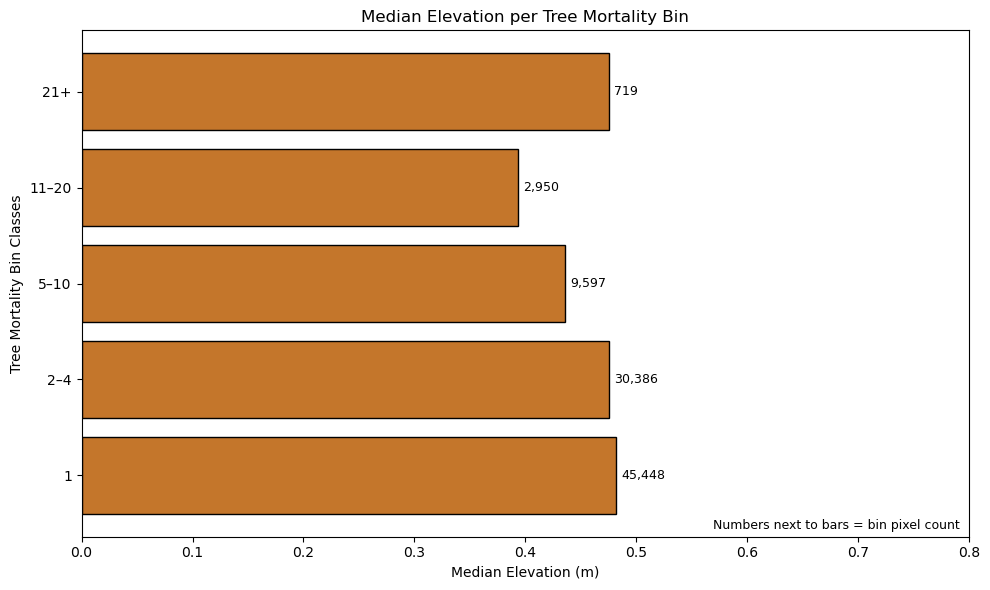

In [41]:
# Create labels for plot
elev_x = np.arange(len(elevation_df))
elev_y_median = elevation_df["Median Elevation (m)"].astype(float)
elev_y_count = elevation_df["Pixel Count"].astype(int)

# Create mortality bin label
elevation_df["Bin Label"] = [
    str(int(row["Lower Threshold"])) if i == 0 else
    f"{int(row['Lower Threshold'])}+" if i == len(elevation_df)-1 else
    f"{int(row['Lower Threshold'])}\u2013{int(row['Upper Threshold'])}"
    for i, row in elevation_df.iterrows()
]

# Define labels for plot
labels = elevation_df["Bin Label"].tolist()

# Create figure, axes, and bars
fig4, ax4 = plt.subplots(figsize=(10, 6))
bars4 = ax4.barh(elev_x, elev_y_median, color="#C4762B", edgecolor="black")

# Set maximum x-axis limit
x_fixed_max = 0.8      
x_threshold = 0.8       

# Calcualte new maximum for x-axis, if threshold is exceeded
data_max = elev_y_median.max()

if data_max <= x_threshold:
    ax4.set_xlim(0, x_fixed_max)
else:
    ax4.set_xlim(0, data_max * 1.15)

# Plot labels and formatting
ax4.set_yticks(elev_x)
ax4.set_yticklabels(elevation_df["Bin Label"])
ax4.set_xlabel("Median Elevation (m)")
ax4.set_ylabel("Tree Mortality Bin Classes")
ax4.set_title("Median Elevation per Tree Mortality Bin")
ax4.text(
    0.99, 0.01,
    "Numbers next to bars = bin pixel count",
    transform=ax4.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
    color="black"
)

# Add pixel counts to the right of each bar
for i, (val, cnt) in enumerate(zip(elev_y_median, elev_y_count)):
    ax4.text(val + (elev_y_median.max()*0.01),  # small offset to the right
            i,
            f"{cnt:,}",
            va="center",
            fontsize=9)

# Plot and save figure
plt.tight_layout()
plt.savefig(
    str(data_directory/"Output_Data"/"Figure_Outputs"/"elevation.png"),
    bbox_inches="tight"
)
plt.show()

### Final Live vs. Dead Tree Analysis

#### Statistical Analyses

### Create Live/Dead Tree Arrays

In [42]:
# Create live tree inundation array
live_tree_inundation_array = arcpy.RasterToNumPyArray(
    live_tree_inundation_raster,
    nodata_to_value=np.nan
)
# Remove NoData values
live_tree_inundation_array = live_tree_inundation_array[
    ~np.isnan(live_tree_inundation_array)
]

print(live_tree_inundation_array.shape)

(523918,)


In [43]:
# Create dead tree inundation array
dead_tree_inundation_array = arcpy.RasterToNumPyArray(
    dead_tree_inundation_raster,
    nodata_to_value=np.nan
)
# Remove NoData values
dead_tree_inundation_array = dead_tree_inundation_array[
    ~np.isnan(dead_tree_inundation_array)
]

print(dead_tree_inundation_array.shape)

(89053,)


In [44]:
# Create live tree elevation array
live_tree_elevation_array = arcpy.RasterToNumPyArray(
    live_tree_elevation_raster,
    nodata_to_value=np.nan
)
# Remove NoData values
live_tree_elevation_array = live_tree_elevation_array[
    ~np.isnan(live_tree_elevation_array)
]

print(live_tree_elevation_array.shape)

(506373,)


In [45]:
# Create dead tree elevation array
dead_tree_elevation_array = arcpy.RasterToNumPyArray(
    dead_tree_elevation_raster,
    nodata_to_value=np.nan
)
# Remove NoData values
dead_tree_elevation_array = dead_tree_elevation_array[
    ~np.isnan(dead_tree_elevation_array)
]

print(dead_tree_elevation_array.shape)


(88020,)


In [46]:
# Create live tree distance to estuary array
live_tree_est_dist_array = arcpy.RasterToNumPyArray(
    live_tree_estuary_distance,
    nodata_to_value=np.nan
)
# Remove NoData values
live_tree_est_dist_array = live_tree_est_dist_array[
    ~np.isnan(live_tree_est_dist_array)
]

print(live_tree_est_dist_array.shape)

(526597,)


In [47]:
# Create dead tree distance to estuary array
dead_tree_est_dist_array = arcpy.RasterToNumPyArray(
    dead_tree_estuary_distance,
    nodata_to_value=np.nan
)
# Remove NoData values
dead_tree_est_dist_array = dead_tree_est_dist_array[
    ~np.isnan(dead_tree_est_dist_array)
]

print(dead_tree_est_dist_array.shape)

(89524,)


In [48]:
# Create live tree distance to artificial drainage array
live_tree_adn_dist_array = arcpy.RasterToNumPyArray(
    live_tree_adn_distance,
    nodata_to_value=np.nan
)
# Remove NoData values
live_tree_adn_dist_array = live_tree_adn_dist_array[
    ~np.isnan(live_tree_adn_dist_array)
]

print(live_tree_adn_dist_array.shape)

(526597,)


In [49]:
# Create dead tree distance to artificial drainage array
dead_tree_adn_dist_array = arcpy.RasterToNumPyArray(
    dead_tree_adn_distance,
    nodata_to_value=np.nan
)
# Remove NoData values
dead_tree_adn_dist_array = dead_tree_adn_dist_array[
    ~np.isnan(dead_tree_adn_dist_array)
]

print(dead_tree_adn_dist_array.shape)

(89524,)


### Live/Dead Pair Statistical Analysis

In [50]:
# Organize your existing arrays into a list of pairs with format: (Variable Name, Live Array, Dead Array)
tasks = [
    ("Inundation Frequency (%)", live_tree_inundation_array, dead_tree_inundation_array),
    ("Elevation (m)", live_tree_elevation_array, dead_tree_elevation_array),
    ("Distance to Estuary (m)", live_tree_est_dist_array, dead_tree_est_dist_array),
    ("Distance to Artificial Drainage (m)", live_tree_adn_dist_array, dead_tree_adn_dist_array)
]

final_results = []

# Loop through each pair
for name, live_arr, dead_arr in tasks:
    
    # Clean out any remaining NaNs
    live_clean = live_arr[~np.isnan(live_arr)]
    dead_clean = dead_arr[~np.isnan(dead_arr)]
    
    # Run the Mann-Whitney U Test - alternative ='two-sided'
    u_stat, p_val = mannwhitneyu(dead_clean, live_clean, alternative='two-sided')

    # Define the sample size for live (n1) and dead (n2) trees
    n1 = len(dead_clean)
    n2 = len(live_clean)
    
    # Calculate rank-biserial correlation (effect size)
    rank_biserial = (2 * u_stat) / (n1 * n2) - 1
    
    # Collect metrics
    final_results.append({
        'Variable': name,
        'Live_Median': np.median(live_clean),
        'Dead_Median': np.median(dead_clean),
        'U_Statistic': u_stat,
        'p_value': p_val,
        'Rank_Biserial_Effect_Size': rank_biserial,
        'Sample_Size_Live': n2,
        'Sample_Size_Dead': n1
    })

# Create a summary table
results_df = pd.DataFrame(final_results)

# Format the p-value for readability
pd.options.display.float_format = '{:.4e}'.format

# Print and save results
print(results_df)
results_df.to_csv(str(data_directory/"Output_Data"/"Figure_Outputs"/"statistic_test_results.csv"))

                              Variable  Live_Median  Dead_Median  U_Statistic  \
0             Inundation Frequency (%)   1.5612e-01   2.7426e-01   3.1071e+10   
1                        Elevation (m)   5.1816e-01   4.7549e-01   1.8855e+10   
2              Distance to Estuary (m)   1.6046e+03   1.6122e+03   2.3837e+10   
3  Distance to Artificial Drainage (m)   4.0804e+02   4.3681e+02   2.3347e+10   

     p_value  Rank_Biserial_Effect_Size  Sample_Size_Live  Sample_Size_Dead  
0 0.0000e+00                 3.3190e-01            523918             89053  
1 0.0000e+00                -1.5395e-01            506373             88020  
2 6.8308e-08                 1.1262e-02            526597             89524  
3 4.9348e-06                -9.5323e-03            526597             89524  
